# SUALBSP-I: Parser and Gurobi Model
This notebook loads `.alb` instances and builds a Gurobi model to minimize the number of stations (Type-I) with sequence-dependent setup times.

Workflow:
1. Parse an instance file.
2. Inspect the parsed data.
3. Build the optimization model.
4. Solve and print the schedule.
5. Plot the station workloads.


In [116]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt


In [117]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Tuple


@dataclass
class SUALBInstance:
    """Container for a SUALBSP instance (extended with state-based setups)."""
    n_tasks: int
    cycle_time: int
    task_times: Dict[int, int]
    precedences: List[Tuple[int, int]]

    # Classical SUALBSP setups (still supported)
    setup_backward: Dict[Tuple[int, int], int]

    # State-based setup model (required in the NEW files)
    n_states: int
    states: Dict[int, str]
    state_hierarchy: Dict[int, List[int]]                 # current_state -> allowed states
    state_transitions: Dict[Tuple[int, int], int]          # (from_state, task) -> to_state
    setup_state_forward: Dict[Tuple[int, int], int]        # (from_state, to_state) -> setup time
    setup_state_cycle: Dict[Tuple[int, int], int]          # (end_state, start_state) -> setup time


def _parse_section(lines: Iterable[str]) -> Dict[str, List[str]]:
    """Parse sections delimited by <section> headers."""
    sections: Dict[str, List[str]] = {}
    current = None

    for raw in lines:
        line = raw.strip()
        if not line:
            continue
        if line.startswith("#"):
            continue

        if line.startswith("<") and line.endswith(">"):
            current = line.strip("<>").strip()
            sections[current] = []
            continue

        if current is None:
            continue

        sections[current].append(line)

    return sections


def parse_alb_file(path: Path) -> SUALBInstance:
    """
    Load a `.alb` file into structured Python data.

    Assumes the NEW files always contain the following state sections:
      <number of states>
      <states>
      <state hierarchy>
      <state transitions>
      <setup times state forward>   # NOW: (from_state,to_state)
      <setup times state cycle>     # (end_state,start_state)

    No fallbacks are used.
    """
    sections = _parse_section(path.read_text().splitlines())

    # ---- basics ----
    n_tasks = int(sections["number of tasks"][0])
    cycle_time = int(sections["cycle time"][0])

    # ---- task times ----
    task_times: Dict[int, int] = {}
    for entry in sections["task times"]:
        task, duration = entry.split()
        task_times[int(task)] = int(duration)

    # ---- precedences ----
    precedences: List[Tuple[int, int]] = []
    for entry in sections["precedence relations"]:
        i, j = entry.split(",")
        precedences.append((int(i), int(j)))

    # ---- classical SUALBSP setups (still supported) ----
    setup_backward: Dict[Tuple[int, int], int] = {}
    for entry in sections.get("setup times backward", []):
        i, rest = entry.split(",")
        j, t = rest.split(":")
        setup_backward[(int(i), int(j))] = int(t)

    # ---- REQUIRED: state model sections (no fallback) ----
    n_states = int(sections["number of states"][0])

    states: Dict[int, str] = {}
    for entry in sections["states"]:
        parts = entry.split(maxsplit=1)
        sid = int(parts[0])
        name = parts[1] if len(parts) > 1 else f"STATE_{sid}"
        states[sid] = name

    # current_state:allowed1,allowed2,...
    state_hierarchy: Dict[int, List[int]] = {}
    for entry in sections["state hierarchy"]:
        left, right = entry.split(":", 1)
        s = int(left.strip())
        allowed = [int(x.strip()) for x in right.split(",") if x.strip() != ""]
        state_hierarchy[s] = allowed

    # (from_state, task) -> to_state
    state_transitions: Dict[Tuple[int, int], int] = {}
    for entry in sections["state transitions"]:
        left, right = entry.split(":")
        s, task = left.split(",")
        state_transitions[(int(s), int(task))] = int(right)

    # (from_state, to_state) -> setup_time   [CHANGED]
    setup_state_forward: Dict[Tuple[int, int], int] = {}
    for entry in sections["setup times state forward"]:
        left, t = entry.split(":")
        s_from, s_to = left.split(",")
        setup_state_forward[(int(s_from), int(s_to))] = int(t)

    # (end_state, start_state) -> setup_time
    setup_state_cycle: Dict[Tuple[int, int], int] = {}
    for entry in sections["setup times state cycle"]:
        left, t = entry.split(":")
        s_end, s_start = left.split(",")
        setup_state_cycle[(int(s_end), int(s_start))] = int(t)

    # ============================================================
    # Hard consistency checks (match the NEW dataset format)
    # ============================================================

    if len(states) != n_states:
        raise ValueError(f"number of states={n_states}, but parsed {len(states)} states from <states>.")

    if len(state_hierarchy) != n_states:
        raise ValueError(
            f"Expected hierarchy for {n_states} states, but got {len(state_hierarchy)} lines in <state hierarchy>."
        )

    # ensure every (state, task) exists for transitions
    for s in states.keys():
        for t in range(1, n_tasks + 1):
            if (s, t) not in state_transitions:
                raise ValueError(f"Missing state transition for (state={s}, task={t}).")

            # and target state is valid
            to_state = state_transitions[(s, t)]
            if to_state not in states:
                raise ValueError(
                    f"Invalid to_state={to_state} in <state transitions> for (state={s}, task={t})."
                )

    # ensure full forward state->state matrix exists
    for s_from in states.keys():
        for s_to in states.keys():
            if (s_from, s_to) not in setup_state_forward:
                raise ValueError(f"Missing setup time state forward for (from={s_from}, to={s_to}).")

    # ensure full cycle matrix exists
    for s_end in states.keys():
        for s_start in states.keys():
            if (s_end, s_start) not in setup_state_cycle:
                raise ValueError(f"Missing setup time state cycle for (end={s_end}, start={s_start}).")

    # ensure hierarchy keys match existing states and values are valid
    for s in states.keys():
        if s not in state_hierarchy:
            raise ValueError(f"Missing hierarchy entry for state {s}.")
        for a in state_hierarchy[s]:
            if a not in states:
                raise ValueError(f"Hierarchy for state {s} references unknown state {a}.")

    return SUALBInstance(
        n_tasks=n_tasks,
        cycle_time=cycle_time,
        task_times=task_times,
        precedences=precedences,
        setup_backward=setup_backward,
        n_states=n_states,
        states=states,
        state_hierarchy=state_hierarchy,
        state_transitions=state_transitions,
        setup_state_forward=setup_state_forward,
        setup_state_cycle=setup_state_cycle,
    )


In [118]:
from pathlib import Path

# Example: parse an instance (no optimization yet)
instance_path = Path("DataSets/MiniSet_Extended.alb")
instance = parse_alb_file(instance_path)

print("=== INSTANCE SUMMARY ===")
print(f"Tasks: {instance.n_tasks}")
print(f"Cycle time: {instance.cycle_time}")
print(f"Task times entries: {len(instance.task_times)}")
print(f"Precedence arcs: {len(instance.precedences)}")

# Classical pair-based setups (still optional in the file)
print(f"Backward setups (pair-based): {len(instance.setup_backward)}")

# --- State model info (required in the new files) ---
print("\n--- State-based setup model ---")
print(f"Number of states: {instance.n_states}")
print(f"States: {len(instance.states)}")
print(f"State hierarchy entries: {len(instance.state_hierarchy)}")
print(f"State transitions (from_state,task -> to_state): {len(instance.state_transitions)}")
print(f"Forward setups (from_state,to_state): {len(instance.setup_state_forward)}")
print(f"Cycle transition setups (end_state,start_state): {len(instance.setup_state_cycle)}")

# Show hierarchy (how the model can "work with it")
print("\n--- Parsed state hierarchy (current -> allowed without setup) ---")
for s in sorted(instance.state_hierarchy.keys()):
    allowed = instance.state_hierarchy[s]
    allowed_str = ", ".join(str(a) for a in allowed)
    print(f"  S{s} -> {{{allowed_str}}}")

# Show forward setup matrix (optional but useful sanity check)
print("\n--- Forward setup matrix (state -> state) ---")
for s_from in sorted(instance.states.keys()):
    row = []
    for s_to in sorted(instance.states.keys()):
        row.append(f"{instance.setup_state_forward[(s_from, s_to)]:>3}")
    print(f"S{s_from} -> " + " ".join(row))

# optional: limit max number of stations
max_stations = None


=== INSTANCE SUMMARY ===
Tasks: 10
Cycle time: 25
Task times entries: 10
Precedence arcs: 9
Backward setups (pair-based): 24

--- State-based setup model ---
Number of states: 3
States: 3
State hierarchy entries: 3
State transitions (from_state,task -> to_state): 30
Forward setups (from_state,to_state): 9
Cycle transition setups (end_state,start_state): 9

--- Parsed state hierarchy (current -> allowed without setup) ---
  S1 -> {1, 2, 3}
  S2 -> {2, 3}
  S3 -> {3}

--- Forward setup matrix (state -> state) ---
S1 ->   0   0   0
S2 ->   2   0   0
S3 ->   3   0   0


In [119]:
import gurobipy as gp
from gurobipy import GRB

# ============================================================
# Basic sets and parameters
# ============================================================
tasks = list(instance.task_times.keys())
n = instance.n_tasks
cycle = instance.cycle_time
ub_stations = max_stations or n
stations = list(range(1, ub_stations + 1))

# State model is present and complete in the new dataset
state_ids = list(range(1, instance.n_states + 1))

# ============================================================
# Sanity checks (match NEW dataset format)
#   - state_transitions: (state, task) -> to_state  (must be complete)
#   - setup_state_forward: (from_state, to_state) -> setup  (must be complete matrix)
#   - setup_state_cycle: (end_state, start_state) -> setup  (must be complete matrix)
# ============================================================
missing_trans = [(s, i) for s in state_ids for i in tasks
                 if (s, i) not in instance.state_transitions]
if missing_trans:
    raise ValueError(
        f"Dataset error: missing state transition entries for {len(missing_trans)} pairs. "
        f"Example missing: {missing_trans[:10]}"
    )

missing_setup_fwd = [(s_from, s_to) for s_from in state_ids for s_to in state_ids
                     if (s_from, s_to) not in instance.setup_state_forward]
if missing_setup_fwd:
    raise ValueError(
        f"Dataset error: missing setup_state_forward entries for {len(missing_setup_fwd)} (from,to) pairs. "
        f"Example missing: {missing_setup_fwd[:10]}"
    )

missing_cycle = [(s_end, s_start) for s_end in state_ids for s_start in state_ids
                 if (s_end, s_start) not in instance.setup_state_cycle]
if missing_cycle:
    raise ValueError(
        f"Dataset error: missing setup_state_cycle entries for {len(missing_cycle)} (end,start) pairs. "
        f"Example missing: {missing_cycle[:10]}"
    )

# hierarchy must be present for each state
if len(instance.state_hierarchy) != instance.n_states:
    raise ValueError(
        f"Dataset error: <state hierarchy> must have {instance.n_states} lines, "
        f"but got {len(instance.state_hierarchy)}."
    )
for s in state_ids:
    if s not in instance.state_hierarchy:
        raise ValueError(f"Dataset error: missing hierarchy entry for state {s}.")

# ============================================================
# Derive FIXED task-state (state category per task)
# We assume (and enforce) that to_state does NOT depend on from_state.
# That matches your generated dataset: task i has a unique state.
# ============================================================
task_state = {}
for i in tasks:
    s_ref = instance.state_transitions[(state_ids[0], i)]
    for s in state_ids[1:]:
        if instance.state_transitions[(s, i)] != s_ref:
            raise ValueError(
                f"Dataset error: task {i} has from_state-dependent transitions: "
                f"{[(s, instance.state_transitions[(s, i)]) for s in state_ids]}"
            )
    task_state[i] = s_ref  # unique state of task i

# Optional consistency: hierarchy says "allowed without setup" should imply 0 forward setup
for s_from in state_ids:
    allowed = set(instance.state_hierarchy[s_from])
    for s_to in state_ids:
        if s_to in allowed and instance.setup_state_forward[(s_from, s_to)] != 0:
            raise ValueError(
                f"Dataset error: hierarchy allows {s_from}->{s_to} without setup, "
                f"but setup_state_forward[{s_from},{s_to}]={instance.setup_state_forward[(s_from, s_to)]} != 0."
            )

# ============================================================
# Model and decision variables
# ============================================================
model = gp.Model("SUALBSP_I_state_to_state_setups")

# Task-to-station assignment
x = model.addVars(tasks, stations, vtype=GRB.BINARY, name="x")
# Station active?
u = model.addVars(stations, vtype=GRB.BINARY, name="u")

# Pairwise ordering (i before j on station k)
z = model.addVars(tasks, tasks, stations, vtype=GRB.BINARY, name="z")

# First / last task on each station
f = model.addVars(tasks, stations, vtype=GRB.BINARY, name="first")
l = model.addVars(tasks, stations, vtype=GRB.BINARY, name="last")

# Position (MTZ)
p = model.addVars(tasks, stations, vtype=GRB.INTEGER, lb=1, ub=n, name="pos")

# adjacency (i directly before j on station k)
adj = model.addVars(tasks, tasks, stations, vtype=GRB.BINARY, name="adj")

# Pair var for last-to-first cycle setup: last_task * first_task
cycle_pair = model.addVars(tasks, tasks, stations, vtype=GRB.BINARY, name="cycle_pair")

# ============================================================
# Assignment constraints
# ============================================================
model.addConstrs((x.sum(i, "*") == 1 for i in tasks), name="assign_once")
model.addConstrs((x.sum("*", k) <= n * u[k] for k in stations), name="use_station")

# ============================================================
# First / Last consistency
# ============================================================
model.addConstrs((f.sum("*", k) == u[k] for k in stations), name="one_first_per_station")
model.addConstrs((l.sum("*", k) == u[k] for k in stations), name="one_last_per_station")
model.addConstrs((f[i, k] <= x[i, k] for i in tasks for k in stations), name="first_only_if_assigned")
model.addConstrs((l[i, k] <= x[i, k] for i in tasks for k in stations), name="last_only_if_assigned")

# ============================================================
# Pairwise ordering (z)
# ============================================================
model.addConstrs((z[i, j, k] <= x[i, k] for i in tasks for j in tasks for k in stations),
                 name="order_only_if_assigned_i")
model.addConstrs((z[i, j, k] <= x[j, k] for i in tasks for j in tasks for k in stations),
                 name="order_only_if_assigned_j")

model.addConstrs(
    (z[i, j, k] + z[j, i, k] <= x[i, k] + x[j, k]
     for i in tasks for j in tasks if i < j for k in stations),
    name="order_upper"
)

model.addConstrs(
    (z[i, j, k] + z[j, i, k] >= x[i, k] + x[j, k] - 1
     for i in tasks for j in tasks if i < j for k in stations),
    name="order_lower"
)

# ============================================================
# MTZ ordering
# ============================================================
big_m = n

model.addConstrs((p[i, k] >= 1 * f[i, k] for i in tasks for k in stations), name="first_pos_lb")
model.addConstrs((p[i, k] <= 1 + (n - 1) * (1 - f[i, k]) for i in tasks for k in stations),
                 name="first_pos_ub")

model.addConstrs((p[i, k] >= n * l[i, k] for i in tasks for k in stations), name="last_pos_lb")
model.addConstrs((p[i, k] <= n + (n - 1) * (1 - l[i, k]) for i in tasks for k in stations),
                 name="last_pos_ub")

model.addConstrs(
    (p[i, k] - p[j, k] + big_m * z[i, j, k]
     <= big_m - 1 + (1 - x[i, k]) * big_m + (1 - x[j, k]) * big_m
     for i in tasks for j in tasks if i != j for k in stations),
    name="mtz_order"
)

# ============================================================
# First precedes all, last has no successor (within station)
# ============================================================
model.addConstrs(
    (z[i, j, k] >= f[i, k] + x[j, k] - 1
     for i in tasks for j in tasks if i != j for k in stations),
    name="first_precedes_all"
)

model.addConstrs(
    (z[i, j, k] <= 1 - l[j, k] + x[i, k]
     for i in tasks for j in tasks if i != j for k in stations),
    name="last_followed_by_none"
)

# ============================================================
# Precedence constraints
# ============================================================
station_index = {i: gp.quicksum(k * x[i, k] for k in stations) for i in tasks}

model.addConstrs(
    (station_index[i] <= station_index[j] for i, j in instance.precedences),
    name="precede_station"
)

model.addConstrs(
    (z[i, j, k] >= x[i, k] + x[j, k] - 1
     for i, j in instance.precedences for k in stations),
    name="precede_order_same_station"
)

# ============================================================
# Adjacency constraints (define immediate successor relation)
# Each assigned task is either first or has exactly one predecessor.
# Each assigned task is either last  or has exactly one successor.
# ============================================================
# forbid self adjacency
model.addConstrs((adj[i, i, k] == 0 for i in tasks for k in stations), name="no_self_adj")

model.addConstrs(
    (gp.quicksum(adj[i, j, k] for i in tasks) + f[j, k] == x[j, k]
     for j in tasks for k in stations),
    name="adj_predecessor_or_first"
)
model.addConstrs(
    (gp.quicksum(adj[i, j, k] for j in tasks) + l[i, k] == x[i, k]
     for i in tasks for k in stations),
    name="adj_successor_or_last"
)

# adjacency implies order
model.addConstrs(
    (adj[i, j, k] <= z[i, j, k] for i in tasks for j in tasks for k in stations),
    name="adj_implies_order"
)

# ============================================================
# Cycle pair linearization: cycle_pair[i,j,k] = l[i,k] * f[j,k]
# Used for last-to-first (cycle) setup time
# ============================================================
for k in stations:
    for i in tasks:
        for j in tasks:
            model.addConstr(cycle_pair[i, j, k] <= l[i, k], name=f"cy_le_last_{k}_{i}_{j}")
            model.addConstr(cycle_pair[i, j, k] <= f[j, k], name=f"cy_le_first_{k}_{i}_{j}")
            model.addConstr(cycle_pair[i, j, k] >= l[i, k] + f[j, k] - 1, name=f"cy_ge_{k}_{i}_{j}")

# ============================================================
# Cycle time constraints with STATE->STATE setups
#
# - Forward setups: between consecutive tasks i->j on station k:
#       setup_state_forward[ state(i), state(j) ] * adj[i,j,k]
#
# - Cycle setup (last-to-first within station k):
#       setup_state_cycle[ state(last), state(first) ] * cycle_pair[last,first,k]
# ============================================================
for k in stations:
    processing = gp.quicksum(instance.task_times[i] * x[i, k] for i in tasks)

    forward_state_setups = gp.quicksum(
        instance.setup_state_forward[(task_state[i], task_state[j])] * adj[i, j, k]
        for i in tasks for j in tasks if i != j
    )

    cycle_transition_setups = gp.quicksum(
        instance.setup_state_cycle[(task_state[i], task_state[j])] * cycle_pair[i, j, k]
        for i in tasks for j in tasks
    )

    model.addConstr(
        processing + forward_state_setups + cycle_transition_setups <= cycle * u[k],
        name=f"cycle_state_{k}"
    )

# ============================================================
# Objective: minimize number of stations
# ============================================================
model.setObjective(gp.quicksum(u[k] for k in stations), GRB.MINIMIZE)


In [120]:
model.update()
model

<gurobi.Model MIP instance SUALBSP_I_state_to_state_setups: 10649 constrs, 3410 vars, Parameter changes: Username=(user-defined), LicenseID=2732783>

In [121]:
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10649 rows, 3410 columns and 31610 nonzeros
Model fingerprint: 0x8c31455b
Variable types: 0 continuous, 3410 integer (3310 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 5418 rows and 1288 columns
Presolve time: 0.40s
Presolved: 5231 rows, 2122 columns, 15587 nonzeros
Variable types: 0 continuous, 2122 integer (2023 binary)
Found heuristic solution: objective 2.0000000

Root relaxation: cutoff, 1830 iterations, 0.13 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

In [122]:
# Print results with setup times (STATE->STATE, using adj + cycle_pair)
if model.status == GRB.OPTIMAL:
    print("Objective value (min #stations):", model.objVal)
    print("Cycle Time C:", cycle)
    print("")

    for k in stations:
        tasks_here = [i for i in tasks if x[i, k].X > 0.5]
        if not tasks_here:
            continue

        # sequence by MTZ positions
        seq = sorted(tasks_here, key=lambda i: p[i, k].X)

        # find first/last tasks
        first_task = next(i for i in tasks_here if f[i, k].X > 0.5)
        last_task = next(i for i in tasks_here if l[i, k].X > 0.5)

        print(f"=== Station {k} ===")
        t = 0

        # Print sequence with explicit forward setups i->j
        for idx, op in enumerate(seq):
            dur = instance.task_times[op]
            start = t

            # processing block starts at 't' (after setup if any)
            # compute setup from previous task (if not first)
            if idx == 0:
                setup = 0
                s_from = None
                s_to = task_state[op]
            else:
                prev = seq[idx - 1]
                s_from = task_state[prev]
                s_to = task_state[op]
                setup = instance.setup_state_forward[(s_from, s_to)]

                if setup > 0:
                    print(
                        f"Setup: S{s_from} -> S{s_to}, "
                        f"setup={setup:3d}, start={start:3d}, end={start + setup:3d}"
                    )
                    t += setup
                    start = t  # task starts after setup

            end = start + dur
            print(
                f"Task {op:2d}: "
                f"state=S{task_state[op]}, "
                f"proc={dur:3d}, "
                f"start={start:3d}, end={end:3d}"
            )
            t = end

        # ---- cycle setup (last_task -> first_task) using state cycle matrix ----
        s_end = task_state[last_task]
        s_start = task_state[first_task]
        cycle_setup = instance.setup_state_cycle[(s_end, s_start)]

        if cycle_setup > 0:
            start = t
            end = start + cycle_setup
            print(
                f"Cycle-setup: last_state=S{s_end} -> first_state=S{s_start}, "
                f"setup={cycle_setup:3d}, start={start:3d}, end={end:3d}"
            )
            t = end

        print(f"Total time on station {k}: {t}")
        print("")

else:
    print("No solution found (status:", model.status, ")")


Objective value (min #stations): 2.0
Cycle Time C: 25

=== Station 1 ===
Task  8: state=S3, proc=  4, start=  0, end=  4
Task  9: state=S3, proc=  6, start=  4, end= 10
Setup: S3 -> S1, setup=  3, start= 10, end= 13
Task 10: state=S1, proc=  3, start= 13, end= 16
Task  6: state=S1, proc=  3, start= 16, end= 19
Task  5: state=S3, proc=  5, start= 19, end= 24
Total time on station 1: 24

=== Station 2 ===
Task  7: state=S2, proc=  2, start=  0, end=  2
Task  4: state=S2, proc=  4, start=  2, end=  6
Task  3: state=S3, proc=  3, start=  6, end=  9
Task  2: state=S2, proc=  2, start=  9, end= 11
Setup: S2 -> S1, setup=  2, start= 11, end= 13
Task  1: state=S1, proc=  1, start= 13, end= 14
Total time on station 2: 14



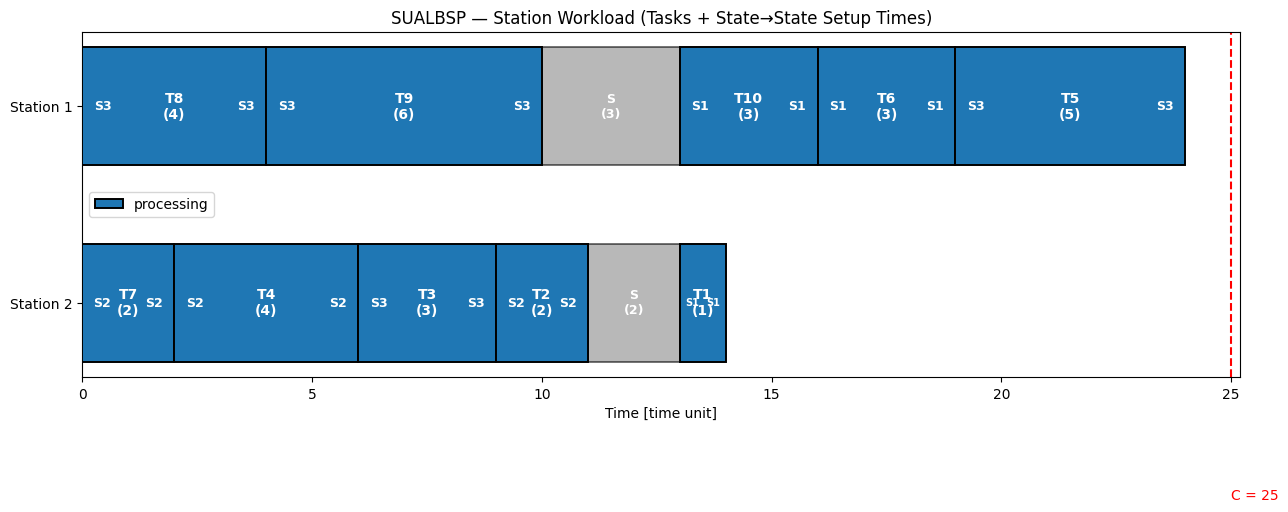

In [123]:
import matplotlib.pyplot as plt

if model.SolCount == 0:
    print("⚠️ No solution — skipping plot.")
else:
    ordered_station_tasks = {}
    for k in stations:
        tasks_here = [i for i in tasks if x[i, k].X > 0.5]
        if tasks_here:
            ordered_station_tasks[k] = sorted(tasks_here, key=lambda i: p[i, k].X)

    # -> higher & more top spacing
    fig, ax = plt.subplots(figsize=(13, 1.6 * len(ordered_station_tasks) + 2))
    plt.subplots_adjust(top=0.76)

    y_labels, y_positions = [], []

    task_color = "#1f77b4"
    setup_color = "#7f7f7f"
    cycle_setup_color = "black"
    bar_height = 0.6

    for row, (k, seq) in enumerate(sorted(ordered_station_tasks.items())):
        y_positions.append(row)
        y_labels.append(f"Station {row + 1}")
        t = 0

        # first/last task on station k
        tasks_here = seq
        first_task = next(i for i in tasks_here if f[i, k].X > 0.5)
        last_task = next(i for i in tasks_here if l[i, k].X > 0.5)

        for idx, op in enumerate(seq):
            dur = instance.task_times[op]
            s_op = task_state[op]

            # --- forward setup from previous task (state->state)
            if idx == 0:
                setup = 0
                s_from = None
            else:
                prev = seq[idx - 1]
                s_from = task_state[prev]
                setup = instance.setup_state_forward[(s_from, s_op)]

            if setup > 0:
                ax.barh(
                    row, setup, left=t, height=bar_height,
                    color=setup_color, alpha=0.55,
                    edgecolor="black", linewidth=1.4,
                    label="setup (state→state)" if (row == 0 and idx == 0) else None,
                )
                ax.text(
                    t + setup / 2, row, f"S\n({setup})",
                    ha="center", va="center",
                    color="white", fontsize=9, fontweight="bold",
                    clip_on=True,
                )
                t += setup

            # --- task bar
            ax.barh(
                row, dur, left=t, height=bar_height,
                color=task_color,
                edgecolor="black", linewidth=1.4, zorder=3,
                label="processing" if (row == 0 and idx == 0) else None,
            )

            # --- task label
            ax.text(
                t + dur / 2, row,
                f"T{op}\n({dur})",
                ha="center", va="center",
                color="white", fontsize=10, fontweight="bold",
                clip_on=True, zorder=4
            )

            # --- state labels inside task bar (start=end=task state in this dataset)
            pad = min(0.25, max(0.06, 0.12 * dur))
            fs_state = 9 if dur >= 1.2 else 7

            # For your generated dataset, each task has a fixed state, so
            # we label the task with S(task_state)
            ax.text(
                t + pad, row, f"S{s_op}",
                ha="left", va="center",
                color="white", fontsize=fs_state, fontweight="bold",
                clip_on=True, zorder=4
            )
            ax.text(
                t + dur - pad, row, f"S{s_op}",
                ha="right", va="center",
                color="white", fontsize=fs_state, fontweight="bold",
                clip_on=True, zorder=4
            )

            t += dur

        # ---- cycle transition setup (last_task_state -> first_task_state) ----
        s_end = task_state[last_task]
        s_start = task_state[first_task]
        cycle_setup = instance.setup_state_cycle[(s_end, s_start)]

        if cycle_setup > 0:
            ax.barh(
                row, cycle_setup, left=t, height=bar_height,
                color=cycle_setup_color, alpha=0.55,
                edgecolor="black", linewidth=1.6,
                label="cycle setup (last→first)" if row == 0 else None,
            )
            ax.text(
                t + cycle_setup / 2, row,
                f"SB\n({cycle_setup})",
                ha="center", va="center",
                color="white", fontsize=9, fontweight="bold",
                clip_on=True
            )
            t += cycle_setup

    # --- cycle time line
    ax.axvline(cycle, linestyle="--", linewidth=1.5, color="red")
    ax.text(cycle, len(ordered_station_tasks), f"C = {cycle}", color="red")

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Time [time unit]")
    ax.set_title("SUALBSP — Station Workload (Tasks + State→State Setup Times)")
    ax.invert_yaxis()

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()

    plt.tight_layout()
    plt.show()
